<a href="https://colab.research.google.com/github/yunions/renewable/blob/master/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 전처리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta, time, datetime
from tqdm import tqdm
import math
# pandas max row 
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [2]:
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100

In [3]:
from warnings import filterwarnings
filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import seaborn as sns
%matplotlib inline
import statsmodels.api as sm

In [27]:
data = pd.read_csv('/content/total_data.csv')
data = data[9:27025] #drop unknwon period(~2017060108, 2020070100~ )
data = data.reset_index(drop = True)
data.columns = ['datetime','solar_result','temp','rain_t','rain_r',
                    'hum','wins', 'wind','sky','altitude','azimuth']
data['datetime'] = pd.to_datetime(data['datetime'], format = '%Y%m%d%H')
data.head()

,datetime,solar_result,temp,rain_t,rain_r,hum,wins,wind,sky,altitude,azimuth
0,2017-06-01 09:00:00,33.12,21.000000,0.0,0.0,65.000000,2.400000,111.000000,1.0,44.23,92.42
1,2017-06-01 10:00:00,50.16,21.333333,0.0,0.0,65.000000,2.333333,112.000000,1.0,NaN,NaN
2,2017-06-01 11:00:00,96.72,21.666667,0.0,0.0,65.000000,2.266667,113.000000,1.0,NaN,NaN
3,2017-06-01 12:00:00,120.96,22.000000,0.0,0.0,65.000000,2.200000,114.000000,1.0,76.04,158.50
4,2017-06-01 13:00:00,118.80,21.333333,0.0,0.0,63.333333,2.433333,107.666667,1.0,NaN,NaN


#01. 학습 데이터 전처리

In [28]:
dataset = data.loc[:,'solar_result' :].astype('float')
dataset.index = data['datetime']
dataset.isnull().sum()

solar_result        0
temp                0
rain_t              0
rain_r              0
hum                 0
wins                0
wind                0
sky                 0
altitude        22512
azimuth         22512
dtype: int64

In [29]:
#시계열 속성 attribute로 추가
dataset['hour'] = data['datetime'].apply(lambda x : x.hour).to_list()
dataset['year'] = data['datetime'].apply(lambda x : x.year).to_list()
dataset['month'] = data['datetime'].apply(lambda x : x.month).to_list()
dataset['day'] = data['datetime'].apply(lambda x : x.day).to_list()

In [30]:
dataset.head()

,solar_result,temp,rain_t,rain_r,hum,wins,wind,sky,altitude,azimuth,hour,year,month,day
datetime,,,,,,,,,,,,,,
2017-06-01 09:00:00,33.12,21.000000,0.0,0.0,65.000000,2.400000,111.000000,1.0,44.23,92.42,9,2017,6,1
2017-06-01 10:00:00,50.16,21.333333,0.0,0.0,65.000000,2.333333,112.000000,1.0,NaN,NaN,10,2017,6,1
2017-06-01 11:00:00,96.72,21.666667,0.0,0.0,65.000000,2.266667,113.000000,1.0,NaN,NaN,11,2017,6,1
2017-06-01 12:00:00,120.96,22.000000,0.0,0.0,65.000000,2.200000,114.000000,1.0,76.04,158.50,12,2017,6,1
2017-06-01 13:00:00,118.80,21.333333,0.0,0.0,63.333333,2.433333,107.666667,1.0,NaN,NaN,13,2017,6,1


## (1) Fill altitude, azimuth NaN
- trial 01 : interpolate
- trial 02 : using mathmatic calculation

In [31]:
night = [20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6] # 밤시간 정의
for i in night : 
  print(f'time : {i}',dataset[dataset['hour'] == i]['solar_result'].unique())

time : 20 [0.   0.24]
time : 21 [0.]
time : 22 [0.]
time : 23 [0.]
time : 0 [0.]
time : 1 [0.]
time : 2 [0.]
time : 3 [0.]
time : 4 [0.]
time : 5 [0.]
time : 6 [ 5.04  4.08  8.4   1.92  0.    6.    0.24 10.08  5.52  5.28  5.76  2.88
  3.84  4.8   2.4   8.16  4.56  2.16  1.2   3.36  0.96  3.12  2.64  1.44
  0.48  3.6   1.68  0.72  6.48  6.24 10.32 11.04  8.64  7.2  10.8   6.96
  7.92  4.32  7.44  6.72  7.68 11.52  8.88  9.12]


In [32]:
#Trial 01 : Interpolate
trial_1 = dataset[['hour','azimuth','altitude']].copy()

for i in trial_1.index :
  if (trial_1.loc[i,'hour'] < 6) or (trial_1.loc[i, 'hour'] > 20)  : 
    trial_1.loc[i,'azimuth'] = 0
    trial_1.loc[i,'altitude'] = 0

trial_1['azimuth'] = trial_1['azimuth'].astype('float').interpolate()
trial_1['altitude'] = trial_1['altitude'].astype('float').interpolate()
trial_1.head(30)

,hour,azimuth,altitude
datetime,,,
2017-06-01 09:00:00,9,92.420000,44.230000
2017-06-01 10:00:00,10,114.446667,54.833333
2017-06-01 11:00:00,11,136.473333,65.436667
2017-06-01 12:00:00,12,158.500000,76.040000
2017-06-01 13:00:00,13,192.333333,68.386667
2017-06-01 14:00:00,14,226.166667,60.733333
2017-06-01 15:00:00,15,260.000000,53.080000
2017-06-01 16:00:00,16,268.450000,40.866667
2017-06-01 17:00:00,17,276.900000,28.653333


In [33]:
# Trial 02 : Mathmethic
# calculate declination
datetime_list = []
declination = []
a = datetime.strptime("2017010100", "%Y%m%d%H")

for i in range(1,371,10) :
  datetime_list.append(a)
  a += timedelta(10)
  dec_v = -23.44*math.cos(math.radians(360/365*(i+10)))
  declination.append(dec_v)

alti_df = pd.DataFrame()
alti_df['time'] = datetime_list
alti_df['declin'] = declination

alti_df.head()

,time,declin
0,2017-01-01,-23.021024
1,2017-01-11,-21.925025
2,2017-01-21,-20.180926
3,2017-01-31,-17.840284
4,2017-02-10,-14.972286


In [34]:
def cal_elev_azi(decl_v,time_value,hour,coord = 35.6) :
  elevation = math.degrees(math.asin(math.sin(math.radians(decl_v))*math.sin(math.radians(coord))+math.cos(math.radians(decl_v))*math.cos(math.radians(coord))*math.cos(math.radians(time_value))))
  azimuth = math.degrees(math.asin((- math.sin(math.radians(time_value))*math.cos(math.radians(decl_v)))/(math.sin(math.radians(90-elevation)))))

  if hour < 5 : azimuth = azimuth
  elif hour < 18 : azimuth = 180 - azimuth
  else : azimuth = 360 + azimuth

  return elevation, azimuth

In [35]:
decli_total = []
time_total = []
ele_total = []
azi_total = []

for i in data['datetime']:
  time_value = -180 + i.hour*15
  time_total.append(time_value)
  coord = 35.6

  base_day = datetime.strptime(str(i.year)+"010100", "%Y%m%d%H")
  diff = (i - base_day).days // 10
  decl_v = alti_df.loc[diff, 'declin']

  elevation,azimuth = cal_elev_azi(decl_v,time_value,i.hour)
  decli_total.append(decl_v)
  ele_total.append(elevation)
  azi_total.append(azimuth)

trial_2 = pd.DataFrame()
trial_2['datetime'] = data['datetime']
trial_2['declination'] = decli_total
trial_2['time_angle'] = time_total
trial_2['elevation'] = ele_total
trial_2['azimuth'] = azi_total
trial_2.index = trial_2.datetime
trial_2.head()

,datetime,declination,time_angle,elevation,azimuth
datetime,,,,,
2017-06-01 09:00:00,2017-06-01 09:00:00,21.852859,-45,48.617684,96.897301
2017-06-01 10:00:00,2017-06-01 10:00:00,21.852859,-30,60.487336,109.600378
2017-06-01 11:00:00,2017-06-01 11:00:00,21.852859,-15,71.021213,132.383793
2017-06-01 12:00:00,2017-06-01 12:00:00,21.852859,0,76.252859,180.000000
2017-06-01 13:00:00,2017-06-01 13:00:00,21.852859,15,71.021213,227.616207


In [41]:
trial = pd.DataFrame()
trial['azimuth01'] = trial_1['azimuth']
trial['altitude01'] = trial_1['altitude']
trial['azimuth02'] = trial_2['azimuth']
trial['altitude02'] = trial_2['elevation']

dataset['altitude'] = trial_1['altitude']
dataset['azimuth'] = trial_1['azimuth']
dataset['altitude_m'] = trial_2['elevation']
dataset['azimuth_m'] = trial_2['azimuth']

### compare

In [ ]:
! pip install plotly==5.1.0
! pip install cufflinks
! pip install chart_studio

In [48]:
import plotly.graph_objects as go

f = go.FigureWidget()
f.add_scatter(y=trial['altitude01'][:100],name = 'Interpolate');
f.add_scatter(y=trial['altitude02'][:100],name = 'Mathmatics');
f.show()

FigureWidget({
    'data': [{'name': 'Interpolate',
              'type': 'scatter',
              'uid': '833…

FigureWidget({
    'data': [{'name': 'Interpolate',
              'type': 'scatter',
              'uid': '833…

In [49]:
import plotly.graph_objects as go

f = go.FigureWidget()
f.add_scatter(y=trial['azimuth01'][:100],name = 'Interpolate');
f.add_scatter(y=trial['azimuth02'][:100],name = 'Mathmatics');
f.show()

FigureWidget({
    'data': [{'name': 'Interpolate',
              'type': 'scatter',
              'uid': '4c8…

FigureWidget({
    'data': [{'name': 'Interpolate',
              'type': 'scatter',
              'uid': '4c8…

<Figure size 1440x576 with 0 Axes>

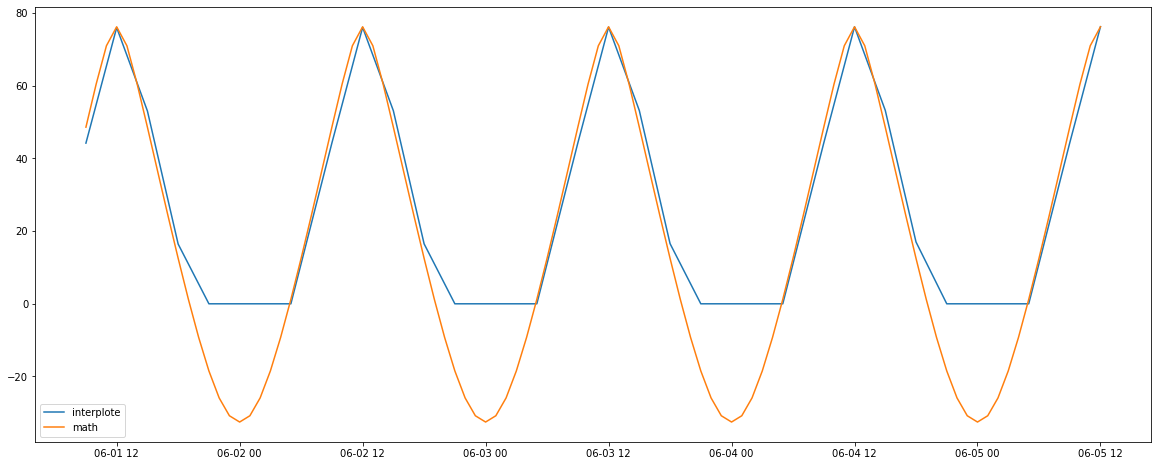

In [37]:
plt.figure(figsize=(20,8))
plt.plot(trial['altitude01'][:100], label = 'interplote')
plt.plot(trial['altitude02'][:100], label = 'math')
plt.legend()
plt.show()

<Figure size 1440x576 with 0 Axes>

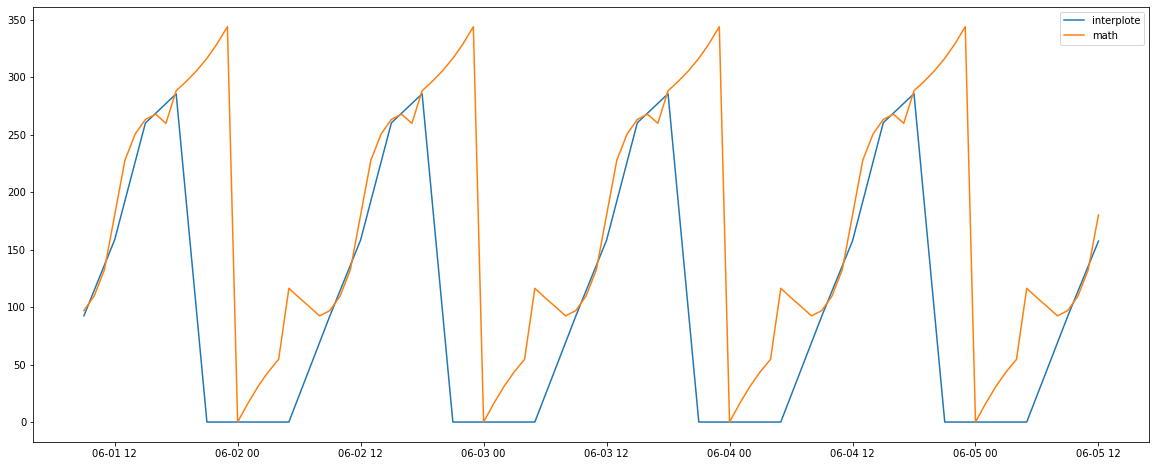

In [39]:
plt.figure(figsize=(20,8))
plt.plot(trial['azimuth01'][:100], label = 'interplote')
plt.plot(trial['azimuth02'][:100], label = 'math')
plt.legend()
plt.show()

## (2) OneHotEncoder

In [42]:
def night(x) :
  if x > 20 or x < 6 : return 1
  else : return 0
  
def season(x) : 
  if x in [12,1,2] : return 0 #winter 
  elif x in [6,7,8] : return 1 #summer
  elif x in [9,10,11] : return 2 #fall
  else : return 3 #sring

In [43]:
from sklearn.preprocessing import OneHotEncoder
sky = pd.DataFrame()
sky['sky'] = dataset['sky'].round().astype('int')
sky['night'] = dataset['hour'].apply(lambda x : night(x))
sky['season'] = dataset['month'].apply(lambda x : season(x))

enc= OneHotEncoder()
enc.fit(sky)

One = enc.transform(sky).toarray()

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [44]:
One_t = np.transpose(One)
x = 0
for i in enc.get_feature_names() :   
  
  dataset[i] = One_t[x]
  x += 1

dataset.head()

,solar_result,temp,rain_t,rain_r,hum,wins,wind,sky,altitude,azimuth,hour,year,month,day,altitude_m,azimuth_m,x0_1,x0_2,x0_3,x0_4,x1_0,x1_1,x2_0,x2_1,x2_2,x2_3
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-06-01 09:00:00,33.12,21.000000,0.0,0.0,65.000000,2.400000,111.000000,1.0,44.230000,92.420000,9,2017,6,1,48.617684,96.897301,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2017-06-01 10:00:00,50.16,21.333333,0.0,0.0,65.000000,2.333333,112.000000,1.0,54.833333,114.446667,10,2017,6,1,60.487336,109.600378,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2017-06-01 11:00:00,96.72,21.666667,0.0,0.0,65.000000,2.266667,113.000000,1.0,65.436667,136.473333,11,2017,6,1,71.021213,132.383793,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2017-06-01 12:00:00,120.96,22.000000,0.0,0.0,65.000000,2.200000,114.000000,1.0,76.040000,158.500000,12,2017,6,1,76.252859,180.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2017-06-01 13:00:00,118.80,21.333333,0.0,0.0,63.333333,2.433333,107.666667,1.0,68.386667,192.333333,13,2017,6,1,71.021213,227.616207,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [51]:
dataset.columns

Index(['solar_result', 'temp', 'rain_t', 'rain_r', 'hum', 'wins', 'wind',
       'sky', 'altitude', 'azimuth', 'hour', 'year', 'month', 'day',
       'altitude_m', 'azimuth_m', 'x0_1', 'x0_2', 'x0_3', 'x0_4', 'x1_0',
       'x1_1', 'x2_0', 'x2_1', 'x2_2', 'x2_3'],
      dtype='object')

In [52]:
dataset.columns = (['solar_result', 'temp', 'rain_t', 'rain_r', 'hum', 'wind', 'wins', 
                    'sky','azimuth', 'altitude', 'hour', 'year', 'month', 'day', 'altitude_m',
                    'azimuth_m','sunny','little cloudy','cloudy','dark cloudy','daytime','night', 'spring', 'summer', 'fall', 'winter'])
dataset.head()

,solar_result,temp,rain_t,rain_r,hum,wind,wins,sky,azimuth,altitude,hour,year,month,day,altitude_m,azimuth_m,sunny,little cloudy,cloudy,dark cloudy,daytime,night,spring,summer,fall,winter
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-06-01 09:00:00,33.12,21.000000,0.0,0.0,65.000000,2.400000,111.000000,1.0,44.230000,92.420000,9,2017,6,1,48.617684,96.897301,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2017-06-01 10:00:00,50.16,21.333333,0.0,0.0,65.000000,2.333333,112.000000,1.0,54.833333,114.446667,10,2017,6,1,60.487336,109.600378,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2017-06-01 11:00:00,96.72,21.666667,0.0,0.0,65.000000,2.266667,113.000000,1.0,65.436667,136.473333,11,2017,6,1,71.021213,132.383793,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2017-06-01 12:00:00,120.96,22.000000,0.0,0.0,65.000000,2.200000,114.000000,1.0,76.040000,158.500000,12,2017,6,1,76.252859,180.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2017-06-01 13:00:00,118.80,21.333333,0.0,0.0,63.333333,2.433333,107.666667,1.0,68.386667,192.333333,13,2017,6,1,71.021213,227.616207,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [53]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27016 entries, 2017-06-01 09:00:00 to 2020-07-01 00:00:00
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   solar_result   27016 non-null  float64
 1   temp           27016 non-null  float64
 2   rain_t         27016 non-null  float64
 3   rain_r         27016 non-null  float64
 4   hum            27016 non-null  float64
 5   wind           27016 non-null  float64
 6   wins           27016 non-null  float64
 7   sky            27016 non-null  float64
 8   azimuth        27016 non-null  float64
 9   altitude       27016 non-null  float64
 10  hour           27016 non-null  int64  
 11  year           27016 non-null  int64  
 12  month          27016 non-null  int64  
 13  day            27016 non-null  int64  
 14  altitude_m     27016 non-null  float64
 15  azimuth_m      27016 non-null  float64
 16  sunny          27016 non-null  float64
 17  little cloudy  

## (3) Corr

<Figure size 1080x1080 with 0 Axes>

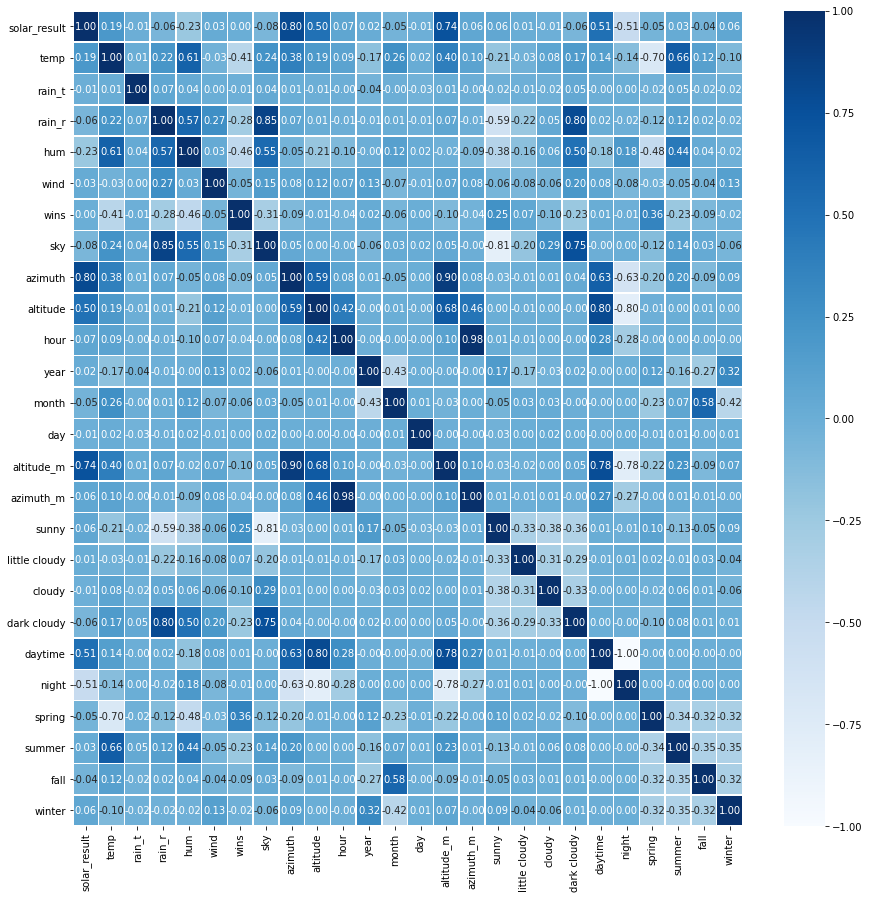

In [54]:
plt.figure(figsize=(15,15))
sns.heatmap(data=dataset.corr(method='pearson'), annot=True,fmt='.2f', linewidths=.5, cmap='Blues')

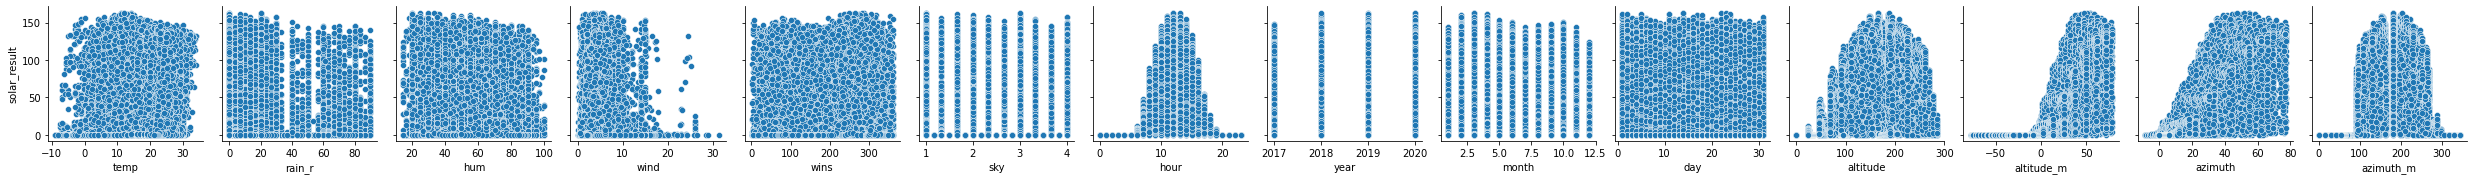

In [55]:
sns.pairplot(dataset, x_vars=['temp', 'rain_r', 'hum', 'wind', 'wins', 'sky', 'hour',
       'year', 'month', 'day', 'altitude','altitude_m','azimuth','azimuth_m'],y_vars=['solar_result'])

### VIF

In [62]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

y = dataset['solar_result']
x = dataset.loc[:,'temp':'azimuth_m']

In [63]:
lm = sm.OLS(y,x)
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           solar_result   R-squared (uncentered):                   0.781
Model:                            OLS   Adj. R-squared (uncentered):              0.781
Method:                 Least Squares   F-statistic:                              6422.
Date:                Tue, 10 Aug 2021   Prob (F-statistic):                        0.00
Time:                        11:57:50   Log-Likelihood:                     -1.2443e+05
No. Observations:               27016   AIC:                                  2.489e+05
Df Residuals:                   27001   BIC:                                  2.490e+05
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
temp          -0.0114      0.030     -0.377      0.706      -0.070       0.048
rain_t        -9.6379      5.421     -1.778      0.075     -20.264       0.988
rain_r         0.0625      0.016      3.999      0.000       0.032       0.093
hum           -0.5163      0.016    -33.019      0.000      -0.547      -0.486
wind          -0.5519      0.064     -8.576      0.000      -0.678      -0.426
wins          -0.0070      0.002     -4.435      0.000      -0.010      -0.004
sky           -0.9407      0.256     -3.671      0.000      -1.443      -0.438
azimuth        1.4733      0.017     87.346      0.000       1.440       1.506
altitude      -0.0084      0.003     -3.093      0.002      -0.014      -0.003
hour           0.9538      0.127      7.490      0.000       0.704       1.203
year           0.0208      0.001     35.964      0.000       0.020       0.022
month          0.1778      0.046      3.861      0.000       0.088       0.268
day           -0.0257      0.017     -1.530      0.126      -0.059       0.007
altitude_m     0.1198      0.010     11.521      0.000       0.099       0.140
azimuth_m     -0.0723      0.009     -7.836      0.000      -0.090      -0.054
==============================================================================
Omnibus:                     1556.145   Durbin-Watson:                   0.275
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5705.463
Skew:                          -0.186   Prob(JB):                         0.00
Kurtosis:                       5.221   Cond. No.                     7.50e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [64]:
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['features'] = x.columns
vif

,VIF Factor,features
0,13.240270,temp
1,1.007841,rain_t
2,8.429129,rain_r
3,46.944897,hum
4,3.869917,wind
5,5.631769,wins
6,21.803073,sky
7,9.449007,azimuth
8,6.678768,altitude
9,134.642260,hour


In [71]:
x_ver1 = x.drop(['day','temp','rain_t','hum','sky','hour','azimuth_m','year','month'],1) #Multicollinearity : azimuth_m, sky / P> 0.05 : month, rain_r

lm = sm.OLS(y, x_ver1)
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           solar_result   R-squared (uncentered):                   0.763
Model:                            OLS   Adj. R-squared (uncentered):              0.763
Method:                 Least Squares   F-statistic:                          1.451e+04
Date:                Tue, 10 Aug 2021   Prob (F-statistic):                        0.00
Time:                        11:59:52   Log-Likelihood:                     -1.2548e+05
No. Observations:               27016   AIC:                                  2.510e+05
Df Residuals:                   27010   BIC:                                  2.510e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
rain_r        -0.2086      0.008    -26.676      0.000      -0.224      -0.193
wind          -0.1484      0.063     -2.366      0.018      -0.271      -0.025
wins           0.0236      0.001     19.082      0.000       0.021       0.026
azimuth        1.5846      0.015    109.193      0.000       1.556       1.613
altitude       0.0134      0.002      6.669      0.000       0.009       0.017
altitude_m     0.0444      0.009      5.219      0.000       0.028       0.061
==============================================================================
Omnibus:                     1572.998   Durbin-Watson:                   0.257
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6881.882
Skew:                          -0.014   Prob(JB):                         0.00
Kurtosis:                       5.472   Cond. No.                         99.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
vif_1 = pd.DataFrame()
vif_1['VIF Factor'] = [variance_inflation_factor(x_ver1.values, i) for i in range(x_ver1.shape[1])]
vif_1['features'] = x_ver1.columns
vif_1

,VIF Factor,features
0,1.954441,rain_r
1,3.398770,wind
2,3.167827,wins
3,6.469682,azimuth
4,3.381916,altitude
5,4.549395,altitude_m


#모델링

In [73]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

def svr_gbr(name = '', train_x = '', train_y = '', test_x = '', test_y = '', SVR_C = 1000.0, gbr_n = 500) :

  svr = make_pipeline(StandardScaler(), SVR(C=SVR_C, epsilon=0.2))
  svr.fit(train_x, train_y)
  print(svr)
  print(f"SVM 훈련 세트 점수: {svr.score(train_x, train_y)} \nSVM 테스트 세트 점수 : {svr.score(test_x, test_y)}")
  gbr = GradientBoostingRegressor(n_estimators= gbr_n)
  gbr.fit(train_x, train_y)
  print(gbr)
  print(f"GBR 훈련 세트 점수: {gbr.score(train_x, train_y)} \nGBR 테스트 세트 점수 : {gbr.score(test_x, test_y)}")

  prediction_svm = svr.predict(test_x)
  prediction_gbr = gbr.predict(test_x)

  df = pd.DataFrame({'result' : test_y, name + 'SVM' : prediction_svm, name + 'gbr' : prediction_gbr})
  
  return df

In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset.loc[:,'temp':], dataset.loc[:,'solar_result'], test_size = 0.75, random_state = 42)

In [81]:
df = svr_gbr('test', X_train, y_train, X_test, y_test,gbr_n=300)
df.head()

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2,
                     gamma='scale', kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)
SVM 훈련 세트 점수: 0.8795601011343415 
SVM 테스트 세트 점수 : 0.7976887121979124
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=300,
                          n_iter_no_change=None, presort='deprecated',
                          

,result,testSVM,testgbr
datetime,,,
2017-10-31 23:00:00,0.00,0.870999,0.326054
2018-02-10 21:00:00,0.00,0.391019,1.021924
2018-08-17 01:00:00,0.00,-0.235488,-0.445957
2018-12-08 03:00:00,0.00,-0.585509,-2.376729
2019-01-10 14:00:00,102.72,88.023026,81.972524


In [82]:
f = go.FigureWidget()
sampling = df.sort_index()
set_period = sampling[20000:]
f.add_scatter(y=set_period['result'],x = set_period.index, name = 'Real result');
f.add_scatter(y=set_period['testSVM'],x = set_period.index, name = 'SVM prediction');
f.add_scatter(y=set_period['testgbr'],x = set_period.index, name = 'GBR prediction');
f.show()

FigureWidget({
    'data': [{'name': 'Real result',
              'type': 'scatter',
              'uid': '233…

FigureWidget({
    'data': [{'name': 'Real result',
              'type': 'scatter',
              'uid': '233…

FigureWidget({
    'data': [{'name': 'Real result',
              'type': 'scatter',
              'uid': '233…

# Grid Search

In [78]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

svr = SVR()

grid_param_svr = {
    'C': [10, 50, 100, 200, 300, 500, 600, 800, 900, 1000],
    'epsilon' : [0.1, 0.2, 0.3]
}

gs_svr = GridSearchCV(estimator=svr, 
                      param_grid=grid_param_svr, 
                      cv=8,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = 1)

%time gs_svr = gs_svr.fit(X_train,y_train)

KeyboardInterrupt: ignored

In [ ]:
gs_svr.best_params_

In [79]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

gbr = GradientBoostingRegressor()

grid_param_svr = {
    'n_estimators': [10, 50, 100, 200, 300, 500, 600, 800, 900, 1000],
}

gs_svr = GridSearchCV(estimator=gbr, 
                      param_grid=grid_param_svr, 
                      cv=8,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = 1)

%time gs_svr = gs_svr.fit(X_train,y_train)

CPU times: user 9min 15s, sys: 488 ms, total: 9min 15s
Wall time: 9min 13s


In [80]:
gs_svr.best_params_

{'n_estimators': 300}